## Data Preparation

In [1]:
# Install libraries
!pip install gensim

    100% |████████████████████████████████| 22.6MB 2.0MB/s 
    100% |████████████████████████████████| 1.4MB 18.0MB/s 
    100% |████████████████████████████████| 133kB 26.7MB/s 
    100% |████████████████████████████████| 4.3MB 10.6MB/s 
    100% |████████████████████████████████| 61kB 20.0MB/s 
    100% |████████████████████████████████| 552kB 23.7MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /content/.cache/pip/wheels/b1/9e/7d/bb3d3b55c597e72617140a0638c06382a5f17283881eae163e
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [0]:
# Load libraries
import pandas as pd
idx = pd.IndexSlice
from gensim.parsing.preprocessing import preprocess_string

**Note:** Fix text cleaning, right now random letters are removed

In [0]:
# Scrape data
def get_southpark_data(seasons_to_scrape = [x for x in range(1,20)]):
  ###
  ### Gets southpark script by season from github repository.  Only has data up through season 19.
  ###
  season_data_list = []
  for season_number in seasons_to_scrape:
    url = "https://raw.githubusercontent.com/BobAdamsEE/SouthParkData/master/by-season/Season-{}.csv".format(season_number)
    season_df = pd.read_csv(url)
    season_df["Episode"] = str(season_number) + "-" + season_df["Episode"].astype(str)
    season_data_list.append(season_df)
  southpark_data = pd.concat(season_data_list)
  southpark_data.reset_index(drop = True,inplace = True)
  southpark_data.set_index(["Season","Episode","Character"],inplace = True)
  return southpark_data

# Clean text
def clean_text(text):
  text.replace("\n"," ") # Remove "\n" that occurs at the end of every string
  cleaned_text = preprocess_string(text)
  # Need phrase detection
  return cleaned_text

class corpus_generator(object):
  def __init__(self,data,cleaned = False):
    self.data = data
    self.cleaned = cleaned
  def __iter__(self):
    for doc in self.data:
      if not self.cleaned:
        yield self._clean_text(doc)
      else:
        yield doc
  def _clean_text(self,text):
    text.replace("\n"," ") # Remove "\n" that occurs at the end of every string
    cleaned_text = preprocess_string(text)
    # Need phrase detection
    return cleaned_text
    
    

Currently only analyzing seasons 1 - 3

In [0]:
# Data formatting
southpark_data_all = get_southpark_data([1,2,3])
southpark_data_all["Line_cleaned"] = [clean_text(doc) for doc in southpark_data_all["Line"]]

In [0]:
def document_merging(data,merge_by):
  results_dict = {}
  merge_by_index = data.index.names.index(merge_by)
  merge_by_levels = data.index.levels[merge_by_index]
  for level in merge_by_levels:
    if merge_by == "Season":
      data_subset = data.loc[idx[level,:,:],:]
    if merge_by == "Episode":
      data_subset = data.loc[idx[:,level,:],:]
    if merge_by == "Character":
      data_subset = data.loc[idx[:,:,level],:]
    new_doc = []
    for doc in data_subset["Line_cleaned"]:
      for token in doc:
        new_doc.append(token)
    results_dict["{}_{}".format(merge_by,level)] = new_doc
    
  return results_dict 

southpark_data_by_season = document_merging(southpark_data_all,"Season")
southpark_data_by_episode = document_merging(southpark_data_all,"Episode")
southpark_data_by_character = document_merging(southpark_data_all,"Character")

## Simple word vectorization


First, let's examine the most important words, or "keywords", spoken by the character Cartman.  The simplest approach is to rank them by how frequently they are spoken.

In [58]:
# Sparse BoW
# Word frequencies
from gensim.corpora import Dictionary

def get_most_common_words(dictionary,corpus_subset,verbose = False):
  bag_of_words = dictionary.doc2bow(corpus_subset)
  named_words = [(dictionary[word_id],frequency) for (word_id,frequency) in bag_of_words]
  sorted_words = sorted(named_words,key = lambda x: x[1],reverse = True)
  if verbose:
    print("Number of unique words in the corpus subset: {}".format(len(dictionary)))
    print("Most common words")
    for i in range(10):
      print(sorted_words[i])
  return sorted_words
    
dictionary = Dictionary(southpark_data_by_character.values())
most_important_words_frequency_Cartman = get_most_common_words(dictionary,southpark_data_by_character["Character_Cartman"],verbose = True)

Number of unique words in the corpus subset: 7743
Most common words
('gui', 235)
('hei', 118)
('mom', 112)
('come', 109)
('like', 101)
('yeah', 96)
('gonna', 91)
('kenni', 88)
('bitch', 78)
('ass', 77)


Now,  let's try using term frequency, inverse document frequency (tf-idf) to extract keywords for Cartman.  This will de-emphasize words which are spoken by multiple characters.  To obtain the tf-idf weighting for words, we treat the entire body of lines spoken by each character as a single document.

**Note:** Investigate different reweighting schemes for tf-idf [link](http://mlwiki.org/index.php/TF-IDF#Good_Weighting_System)

In [7]:
# TF-IDF
# A reweighting of word frequency proportional to term frequency and inversely proportional to document frequency
from gensim.models import TfidfModel

def get_important_words_tfidf(dictionary,corpus,corpus_subset,verbose = False):
  corpus_bag_of_words = (dictionary.doc2bow(doc) for doc in corpus) # Transforms corpus to bag of words representation
  corpus_subset_bag_of_words = dictionary.doc2bow(corpus_subset)
  model = TfidfModel(corpus_bag_of_words)  # Creates tf-idf weights
  corpus_subset_tfidf = model[corpus_subset_bag_of_words]
  named_words = [(dictionary[word_id],weight) for (word_id,weight) in corpus_subset_tfidf]
  sorted_words = sorted(named_words,key = lambda x: x[1],reverse = True)
  if verbose:
    print("Most important words by tf-idf weighting")
    for i in range(10):
      print(sorted_words[i])
  return sorted_words
  
most_important_words_tfidf_Cartman = get_important_words_tfidf(dictionary,southpark_data_by_character.values(),southpark_data_by_character["Character_Cartman"],verbose = True)


Most important words by tf-idf weighting
('gui', 0.37706196961345956)
('mom', 0.2640735476250679)
('kenni', 0.18723997683637092)
('kitti', 0.16817126890026224)
('bitch', 0.16027546852681487)
('hei', 0.15917684198677282)
('dude', 0.14925902863195967)
('ass', 0.13532278214298543)
('gonna', 0.12932740335500675)
('serious', 0.12426354418173974)


BM25 document retrieval algorithm


[reference](https://en.wikipedia.org/wiki/Okapi_BM25)

In [0]:
# BM25/BM25+

The code below features the Contextual Salience algorithm, a new approach on existing word importance measures which takes context into account.

[arixv](https://arxiv.org/pdf/1803.08493.pdf)

In [0]:
import numpy as np
class contextual_salience_model(object):
  def __init__(self,corpus_vectorized):
    # corpus needs to be in matrix form or we need to transform it here
    self.corpus_vectorized = corpus_vectorized
  
  def __iter__(self):
    # Go through corpus and apply contextual salience algorithm
    # Need to implement
    # ALSO NEED TO MAKE SURE DIMENSIONS LINE UP
    S_corpus = None
    
    for doc in self.corpus_vectorized:
      S_doc = None
      yield self._contextual_salience(doc,S_doc,S_corpus)

  def _contextual_salience(self,vector,S_doc,S_corpus):
    ###
    ### vector is a px1 vector representation of the document
    ### S_doc is the covariance of the vector representations of the document (pxp)
    ### S_corpus is the covariance of the vector representations of the corpus (pxp)
    ###
    S_doc_weighted = S_doc
    S_corpus_weighted = S_corpus
    return np.sqrt(vector.transpose() @ np.multiply(S_doc_weighted,S_corpus_weighted) @ vector)  


def get_important_words(vector,doc,corpus):
  corpus_bag_of_words = (dictionary.doc2bow(doc) for doc in corpus) # Transforms corpus to bag of words representation


How do a character's characteristic keywords change from season to season?

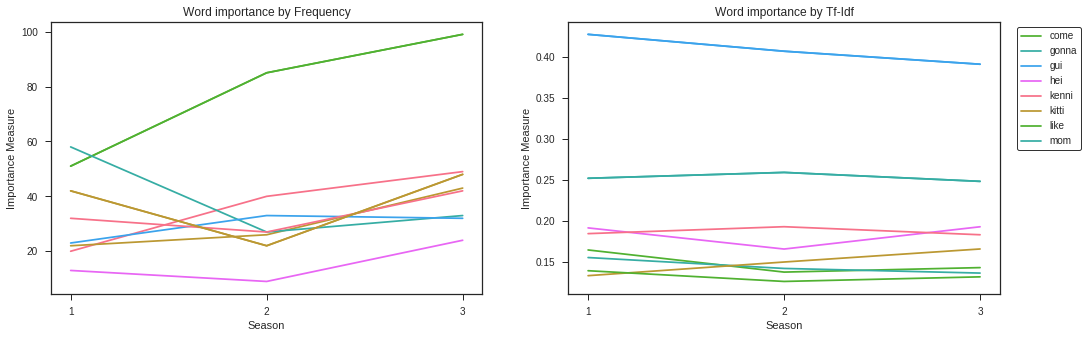

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import OrderedDict

# Control graph defaults
sns.set_style("ticks")

def get_word_importance_data(character,data):
  # Get seasons to compare from data
  season_multindex = data.index.names.index("Season")
  seasons_to_compare = data.index.levels[season_multindex]
  
  # Get vocab to initialize results dataframe
  all_season_vocabulary = [word for word in Dictionary(data["Line_cleaned"]).values()]
  results_df = pd.DataFrame(columns = ["Season","Method"] + all_season_vocabulary)
  top_5_common_words = set()
  top_5_important_words_tfidf = set()
  
  for season_number in seasons_to_compare:
    # Get dictionary for season
    season_subset = data.loc[idx[season_number,:,:],:]
    data_by_character = document_merging(season_subset,"Character")
    dictionary = Dictionary(data_by_character.values())
    
    # Get most common words
    most_common_words = get_most_common_words(dictionary,data_by_character[character])
    words_to_add = set([tup[0] for tup in most_common_words[0:5]])
    top_5_frequency = top_5_common_words.union(words_to_add)
    
    temp_df = pd.DataFrame(dict(most_common_words),index = [0])
    temp_df["Season"] = season_number
    temp_df["Method"] = "Frequency"
    results_df = results_df.append(temp_df)
    
    # Get most important words via tf-idf
    most_important_words_tfidf = get_important_words_tfidf(dictionary,data_by_character.values(),southpark_data_by_character[character])
    words_to_add = set([tup[0] for tup in most_important_words_tfidf[0:5]])
    top_5_tfidf = top_5_important_words_tfidf.union(words_to_add)
    
    temp_df = pd.DataFrame(dict(most_important_words_tfidf),index = [0])
    temp_df["Season"] = season_number
    temp_df["Method"] = "Tf-Idf"
    results_df = results_df.append(temp_df)
    
    # More word importance measures go here
    
    # Set all 0 indices to proper order
    results_df.reset_index(drop = True,inplace = True)

  return results_df,list(top_5_frequency),list(top_5_tfidf)

def make_word_importance_graphs(character,data):
  results_df,top_5_frequency,top_5_tfidf = get_word_importance_data(character,data)
  graph_df = results_df.loc[:,["Season", "Method"] + top_5_frequency + top_5_tfidf]
  
  words_to_graph = sorted(list(set(top_5_frequency + top_5_tfidf)))
  seasons = list(graph_df["Season"].unique())
  fig,axes = plt.subplots(1,2,figsize = (17,5))
  
  my_palette = itertools.cycle(sns.color_palette("husl")) # graph wasn't properly cycling through colors
  
  # Word importance for each method
  methods_to_plot = list(graph_df["Method"].unique())
  for axis,method in zip(fig.axes,methods_to_plot):
    row_mask = graph_df["Method"] == method
    x = graph_df.loc[row_mask,["Season"]]
    
    # Plot importance for each word
    for word in words_to_graph:
      y = graph_df.loc[row_mask,[word]]
      axis.plot(x,y,label = word,color = next(my_palette))

    # Format graph
    axis.set_title("Word importance by {}".format(method))
    axis.set_xlabel("Season")
    axis.set_xticks(seasons)
    axis.set_ylabel("Importance Measure")

  # Other graph formatting
  
  handles, labels = axis.get_legend_handles_labels()
  by_label = OrderedDict(zip(labels, handles))
  leg = axis.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.2,1), loc="upper right",frameon = True,edgecolor = "black")
  leg.get_frame().set_linewidth(1)
  plt.show()

make_word_importance_graphs("Character_Cartman",southpark_data_all)

## Embedding Techniques

How can we mathematically represent the lines spoken by each character in such a way that the similarity between character lines is preserved?  By using word2vec and doc2vec, we can "embed" the words and lines spoken by each character into a low dimensional space where similar words and lines are close to each other.

Let's try finding words which are similar to Cartman.


**Note:** Investigate PMI, smoothing/regularization can be done to improve results

[article](https://multithreaded.stitchfix.com/blog/2017/10/18/stop-using-word2vec/) on effectiveness of this method vs word2vec

In [0]:
# Word2Vec
from gensim.models import Word2Vec

model_w2v = Word2Vec(southpark_data_all["Line_cleaned"],size = 300,iter = 1000)

In [78]:
model_w2v.wv.most_similar(positive = ["cartman"])

[('think', 0.34619569778442383),
 ('kyle', 0.31974905729293823),
 ('gui', 0.3036838173866272),
 ('like', 0.29474273324012756),
 ('yeah', 0.2566911578178406),
 ('know', 0.2540469169616699),
 ('hei', 0.24339362978935242),
 ('god', 0.24206410348415375),
 ('kenni', 0.2406468689441681),
 ('got', 0.23828786611557007)]

In [86]:
# Cartman's signature line is "screw you guys"
model_w2v.wv.most_similar(positive=["screw","gui"])

[('dude', 0.300290048122406),
 ('come', 0.23482705652713776),
 ('gonna', 0.23349641263484955),
 ('mom', 0.22244280576705933),
 ('kenni', 0.21986979246139526),
 ('yeah', 0.20225341618061066),
 ('kid', 0.19998086988925934),
 ('tweek', 0.1987067312002182),
 ('dad', 0.19795963168144226),
 ('sissi', 0.19290632009506226)]

If we embed entire lines using doc2vec, we can easily find similar lines.

In [0]:
# Doc2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
class tagged_doc_generator(object):
  def __init__(self,data = southpark_data_all["Line_cleaned"]):
    self.data = data
  
  def __iter__(self):
    for index,doc in enumerate(self.data):
      yield TaggedDocument(words = doc,tags = [index])

class doc2vec_class(object):
  def __init__(self,vector_size = 100,epochs = 1000,doc_generator = tagged_doc_generator()):
    self.vector_size = vector_size
    self.epochs = epochs
    self.doc_generator = doc_generator
    
    self.model = Doc2Vec(self.doc_generator,self.vector_size,self.epochs)
    
  def get_most_similar_docs(self,words):
    new_vector = self.model.infer_vector(words)
    similar_documents = self.model.docvecs.most_similar([new_vector])
    for tup in similar_documents:
      print("Similarity: {}".format(tup[1]))
      print(southpark_data_all.iloc[tup[0],southpark_data_all.columns.get_loc("Line")])
    
model_d2v = doc2vec_class()

In [97]:
words = ["screw","gui"]
model_d2v.get_most_similar_docs(words)

Similarity: 0.3997606039047241
That's it! We gotta learn that song backwards.

Similarity: 0.37514644861221313
I wanted to make sure, too.

Similarity: 0.37188810110092163
You're just jealous! Why don't you go back to Endor you stupid wookie?!

Similarity: 0.36199289560317993
Well, nobody can say for sure; uh, no motive has yet been established.

Similarity: 0.3556004762649536
At long last I have foundA true reason to beNow I feel I can start anew--  Woo, whoa! Ow! Hey!  Uh oh hel-m. Hey!

Similarity: 0.3434444069862366
Kick the baby! 

Similarity: 0.33249035477638245
It's great to have you back Chef!

Similarity: 0.3310459554195404
Nu-how, Skeeter. She ain't hurtin' nobody.

Similarity: 0.3212505578994751
Oh, you didn't see it? Oh. Tweek's family was on the news saying what a wuss you are, Craig.

Similarity: 0.3147032856941223
Oohma poota!



Technique to significantly improve word embedding performance

[paper](https://openreview.net/pdf?id=SyK00v5xx)

In [0]:
# A simple but tough to beat baseline for sentence embeddings

Poincare embeddings

[arxiv](https://arxiv.org/pdf/1705.08039.pdf)

Dense Cohort of Terms, a technique from a 2013 paper that improves upon BoW representations.

[arxiv](https://arxiv.org/pdf/1301.6770.pdf)

In [0]:
# Dense cohort of terms

Embeds words into a low dimensional space using Singular Value Decomposition

In [0]:
# Latent Semantic Indexing/Analysis (LSI/LSA)
from gensim.models import LsiModel
model_lsi = LsiModel([dictionary.doc2bow(doc) for doc in southpark_data_all["Line_cleaned"]],num_topics = 300,id2word = dictionary)

## Topic Modeling

[This](https://blog.insightdatascience.com/topic-modeling-and-sentiment-analysis-to-pinpoint-the-perfect-doctor-6a8fdd4a3904) post might be useful

[Paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.163.5917&rep=rep1&type=pdf) on joint topic-sentiment modeling

In [0]:
# Latent Dirichlet Allocation (LDA)

## Predicting Character Lines

We've up with with different ways to represent lines in Southpark, let's see if we can determine the authorship of any given line.